In [2]:
import os
import pandas as pd
import xml.etree.ElementTree as et
import librosa
import librosa.display
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis
from tqdm import tqdm

In [88]:
ANNOTATION_PATH = '../data/IDMT-SMT-GUITAR_V2/dataset2/annotation'
AUDIO_PATH_ROOT = '../data/IDMT-SMT-GUITAR_V2/dataset2/audio'

In [89]:
annotation_files = os.listdir(ANNOTATION_PATH)
annotation_files.sort()
len(annotation_files)

87

In [102]:
dataset = pd.DataFrame()
for i, annotation_file in tqdm(enumerate(annotation_files)):
    annotation_file_path = os.path.join(ANNOTATION_PATH, annotation_file)

    annotation_tree = et.parse(annotation_file_path)
    annotation_root = annotation_tree.getroot()
    global_params = annotation_root.find('globalParameter')
    transcription = annotation_root.find('transcription')

    params = []
    params_value = []
    for param in global_params:
        params.append(param.tag)
        params_value.append(param.text)
    params_value[0] = annotation_file[:-3] + 'wav'

    total_event = len(transcription.findall('event'))
    df_globalParams = pd.DataFrame([params_value]*total_event, columns=params)

    transcription_tag = ['expressionStyle', 'excitationStyle', 'onsetSec', 'offsetSec', 'duration']
    df_transcription = pd.DataFrame(columns=transcription_tag)
    for tag in transcription_tag:
        if tag != 'duration':
            values = []
            for value in transcription.iter(tag):
                values.append(value.text)
            df_transcription[tag] = values
    df = pd.concat([df_transcription, df_globalParams], axis=1)
    if i == 0:
        dataset = df
    else:
        dataset = dataset.append(df)
dataset = dataset.reset_index(drop=True)
dataset['onsetSec'] = pd.to_numeric(dataset['onsetSec'])
dataset['offsetSec'] = pd.to_numeric(dataset['offsetSec'])
dataset['duration'] = dataset['offsetSec'] - dataset['onsetSec']

idx = []
for i in range(dataset.shape[0]):
    if (('Lick' in dataset['audioFileName'][i]) and \
        (dataset['expressionStyle'][i] == 'NO') and \
        (dataset['excitationStyle'][i] == 'PK')):
        idx.append(i)
dataset = dataset.drop(idx)
dataset = dataset.reset_index(drop=True)

87it [00:00, 94.83it/s]


In [103]:
print(dataset.shape)
dataset

(1323, 15)


,expressionStyle,excitationStyle,onsetSec,offsetSec,duration,audioFileName,instrument,instrumentModel,pickUpSetting,instrumentTuning,recordingDate,recordingArtist,instrumentBodyMaterial,instrumentStringMaterial,composer
0,NO,PK,1.5790,2.2409,0.6619,AR_A_fret_0-20.wav,EGUI,Aristides 010,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling
1,NO,PK,2.6026,3.3066,0.7040,AR_A_fret_0-20.wav,EGUI,Aristides 010,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling
2,NO,PK,3.6949,4.3970,0.7021,AR_A_fret_0-20.wav,EGUI,Aristides 010,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling
3,NO,PK,4.7456,5.4846,0.7390,AR_A_fret_0-20.wav,EGUI,Aristides 010,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling
4,NO,PK,5.8514,6.5035,0.6521,AR_A_fret_0-20.wav,EGUI,Aristides 010,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling


In [104]:
expressionStyle = pd.value_counts(dataset['expressionStyle']).reset_index()
expressionStyle.columns = ['Expression Style', 'Number']
px.bar(expressionStyle, x='Expression Style', y='Number', width=400, height=300)

In [105]:
excitationStyle = pd.value_counts(dataset['excitationStyle']).reset_index()
excitationStyle.columns = ['Excitation Style', 'Number']
px.bar(excitationStyle, x='Excitation Style', y='Number', width=400, height=300)

In [109]:
count = 0
for i in range(dataset.shape[0]):
    if (dataset['expressionStyle'][i] == 'NO') and \
       (dataset['excitationStyle'][i] == 'PK'):
        count += 1
count

378

In [110]:
def get_features(path, start_time, duration, sr=44100, n_mfcc=13, mode='mirror', n_fft=1024, hop_length=512):
    signal, sr = librosa.load(path, sr=sr, offset=start_time, duration=duration)

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    delta_mfcc = librosa.feature.delta(mfcc, mode=mode)
    delta2_mfcc = librosa.feature.delta(mfcc, mode=mode, order=2)

    mfccs = np.hstack((
                    np.mean(mfcc, axis=1),
                    np.std(mfcc, axis=1),
                    skew(mfcc, axis=1),
                    kurtosis(mfcc, axis=1)
                ))
    delta_mfccs = np.hstack((
                    np.mean(delta_mfcc, axis=1),
                    np.std(delta_mfcc, axis=1),
                    skew(delta_mfcc, axis=1),
                    kurtosis(delta_mfcc, axis=1)
                ))
    delta2_mfccs = np.hstack((
                    np.mean(delta2_mfcc, axis=1),
                    np.std(delta2_mfcc, axis=1),
                    skew(delta2_mfcc, axis=1),
                    kurtosis(delta2_mfcc, axis=1)
                ))

    extracted_features = np.hstack((mfccs, delta_mfccs, delta2_mfccs))
    return extracted_features

In [111]:
data = []
for i in tqdm(range(dataset.shape[0])):
    filename = dataset['audioFileName'][i]
    expression_style = dataset['expressionStyle'][i]
    excitation_style = dataset['excitationStyle'][i]
    onset = dataset['onsetSec'][i]
    duration = dataset['duration'][i]
    audio_path = os.path.join(AUDIO_PATH_ROOT, filename)

    features = get_features(audio_path, onset, duration)
    features = np.append(features, [expression_style, excitation_style, onset, duration, filename])
    data.append(features)

100%|██████████| 1323/1323 [00:44<00:00, 29.49it/s]


In [112]:
columns = []
names = ['mfcc', 'delta_mfcc', 'delta2_mfcc']
stats = ['mean', 'std', 'skew', 'kurtosis']
file_desc = ['expression_style', 'excitation_style', 'start_time', 'duration', 'filename']

for name in names:
    for stat in stats:
        for i in range(13):
            col = f'{stat}_{name}_{i+1}'
            columns = np.append(columns, col)

columns = np.append(columns, file_desc)
my_dataset = pd.DataFrame(data, columns=columns)
my_dataset.shape

(1323, 161)

In [113]:
my_dataset.to_csv('../data/guitar.csv', index=False)

In [116]:
for i in range(my_dataset.shape[0]):
    if 'Lick' in my_dataset['filename'][i]:
        print(my_dataset['filename'][i])

AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_FNVSBHD.wav
AR_Lick11_

ACCURACY: 85.714% 
MCC: 80.112% 
              precision    recall  f1-score   support

          BE       0.62      0.67      0.64        12
          DN       1.00      1.00      1.00        30
          HA       1.00      0.82      0.90        11
          NO       0.84      0.92      0.88        59
          SL       1.00      0.55      0.71        11
          VI       0.64      0.70      0.67        10

    accuracy                           0.86       133
   macro avg       0.85      0.77      0.80       133
weighted avg       0.87      0.86      0.86       133



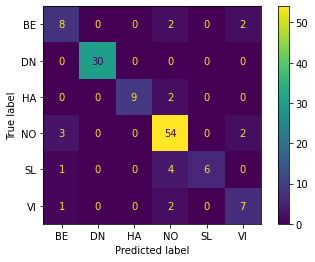

In [125]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef, classification_report, plot_confusion_matrix

X = my_dataset.iloc[:,:156]
y = my_dataset['expression_style']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.90, random_state=42)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

c = 1
s = 1
clf = SVC(kernel='rbf', C=2**c, gamma=1/(2*(2**s)**2), decision_function_shape='ovo')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("ACCURACY: {:.3f}% ".format(accuracy_score(y_test, y_pred) * 100))
print("MCC: {:.3f}% ".format(matthews_corrcoef(y_test, y_pred) * 100))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(clf, X_test, y_test)
plt.show()